In [804]:
import cv2
import glob
import os
import pandas as pd
import numpy as np
import subprocess

# general imports
from copy import deepcopy
from pathlib import Path
from PIL import Image, ImageOps
from scipy.signal import resample

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, MSELoss, SmoothL1Loss
from torch.optim import Adam, SGD, lr_scheduler, LBFGS, RAdam, AdamW
from torch.utils.data import DataLoader
from torchmetrics import PeakSignalNoiseRatio
from adabelief_pytorch import AdaBelief
#from torchviz import make_dot

In [805]:
def generate_cdr1_to_cdr3_pdb(path, keepABC=True, lresidues=False):
    list_residues = ['START']
    with open(path, 'r') as f: # needs to be Chothia-numbered
        content = f.readlines()
        header_lines_important = range(4)
        header_lines = [content[i][0]=='R' for i in range(len(content))].count(True)
        h_range = range(26, 103)
        l_range = range(24, 98)
        chain_range = slice(21, 22)
        res_range = slice(23, 26)
        res_extra_letter = 26 #sometimes includes a letter 'A', 'B', 'C', ...
        h_chain_key = 'HCHAIN'
        l_chain_key = 'LCHAIN'
        idx_list = list(header_lines_important)
        new_path = path[:-4] + '_CDR1_to_CDR3' + path[-4:]
        
        # Getting the names of the heavy and light chains
        line = content[header_lines_important[-1]]
        if line.find(h_chain_key) != -1:
            h_pos = line.find(h_chain_key) + len(h_chain_key) + 1
            h_chain = line[h_pos:h_pos+1]
            
            # Obtaining the CDR1 to CDR3 lines for both chains
            for i, line in enumerate(content[header_lines:]):
                if line[chain_range].find(h_chain) != -1 and int(line[res_range]) in h_range:
                    if line[res_extra_letter] == ' ' or keepABC == True:
                        idx_list.append(i+header_lines)
                        if lresidues == True:
                            full_res = line[chain_range] + line[res_range] + line[res_extra_letter]
                            if full_res != list_residues[-1]:
                                list_residues.append(full_res)
        
        #line = content[header_lines_important[-1]]                       
        #if line.find(l_chain_key) != -1:
        #    l_pos = line.find(l_chain_key) + len(l_chain_key) + 1
        #    l_chain = line[l_pos:l_pos+1]
            
        #    # This separation ensures that heavy chain residues are enlisted first
        #    for i, line in enumerate(content[header_lines:]):
        #        if line[chain_range].find(l_chain) != -1 and int(line[res_range]) in l_range:
        #            if line[res_extra_letter] == ' ' or keepABC == True:
        #                idx_list.append(i+header_lines)
        #                if lresidues == True:
        #                    full_res = line[chain_range] + line[res_range] + line[res_extra_letter]
        #                    if full_res != list_residues[-1]:
        #                        list_residues.append(full_res)                   
    
    # List with name of every residue is saved if selected
    if lresidues == True:
        list_residues.append('END')
        np.save('/Users/kevinmicha/Documents/PhD/predicting-affinity/lists_of_residues/'+path[-8:-4]+'.npy', list_residues)
                        
                    
    # Creating new file
    with open(new_path, 'w') as f_new:
        f_new.writelines([content[l] for l in idx_list])

In [806]:
# Getting entries with affinity and antigen information
df = pd.read_csv('sabdab_summary_all.tsv', sep='\t', header=0)[['pdb', 'antigen_type', 'affinity']]
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag', '3etb', '3gkz', '3uze', '3uzq', '4f9l', '4gqp', '4r2g', '5c6t']
df.drop_duplicates(keep='first', inplace=True)
df = df[(df.antigen_type.notna()) & (df.antigen_type != 'NA')][['pdb', 'affinity']]
df = df[(df.affinity.notna()) & (df.affinity != 'None')]
df = df[~df['pdb'].isin(pathological)] # Removing pathological cases 
entries = list(df['pdb'])
affinity = list(df['affinity'])
modes = 30 # 'all' if no limit is desired, otherwise a number is required
numbering = ''
selection = '_CDR1_to_CDR3'
folder = str(Path.home() / 'Downloads') + '/all_structures/chothia/'
file_type_input = '.pdb'
dccm_map_path = 'dccm_maps/'

# Uncomment to generate

#for entry in entries:
#    file_name = entry + numbering + selection
#    path = folder + file_name + file_type_input
#    new_path = dccm_map_path + entry
#    generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input) 
#    subprocess.call(['/usr/local/bin/RScript pdb_to_dccm.r ' + str(path) + ' ' + str(new_path) + ' ' + str(modes)], shell=True, stdout=open(os.devnull, 'wb'))#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))
#
#
#    if os.path.exists(path):
#        os.remove(path)

In [807]:
dccm_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))
selected_entries = [dccm_paths[i][-8:-4] for i in range(len(dccm_paths))]
heavy = np.load('chain_lengths/heavy_lengths.npy').astype(int)
#light = np.load('chain_lengths/light_lengths.npy').astype(int)

assert list(np.load('chain_lengths/selected_entries.npy')) == selected_entries

for entry in selected_entries:
    assert len(np.load('/Users/kevinmicha/Documents/PhD/predicting-affinity/lists_of_residues/'+entry+'.npy'))-2 == heavy[selected_entries.index(entry)] #+ light[selected_entries.index(entry)]

# Uncomment to get the lengths (of the light and heavy chains) and lists of residues

#heavy = []
##light = []

#for entry in selected_entries:
#    file_name = entry + numbering + selection
#    path = folder + file_name + file_type_input
#    new_path = dccm_map_path + entry
#    generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input, keepABC=True, lresidues=True)
#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))
#   
#    if os.path.exists(path):
#        os.remove(path)
#    h, l = np.load('/Users/kevinmicha/Downloads/value.npy') # there might be a neat solution
#
#    heavy.append(h)
#    #light.append(l)
#np.save('heavy_lengths.npy', heavy)
##np.save('light_lengths.npy', light)
#np.save('selected_entries.npy', selected_entries)

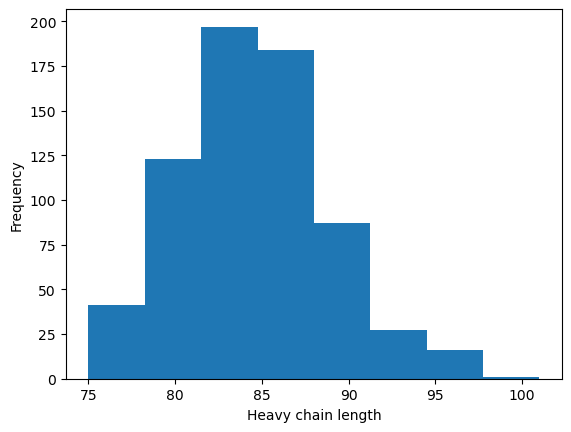

In [808]:
plt.hist(heavy, 8)
plt.xlabel('Heavy chain length')
plt.ylabel('Frequency')
plt.show()

In [809]:
#plt.hist(light, 8)
#plt.xlabel('Light chain length')
#plt.ylabel('Frequency')
#plt.show()

In [810]:
#plt.hist([sum(x) for x in zip(heavy, light)], 8)
#plt.xlabel('Total length')
#plt.ylabel('Frequency')
#plt.show()

In [811]:
# Code that obtains the longest/shortest possible chain

def noABC(residue):
    return residue[:-1]

residue_path = 'lists_of_residues/'
file_residues_paths = sorted(glob.glob(os.path.join('/Users/kevinmicha/Documents/PhD/predicting-affinity/'+residue_path, '*.npy')))
max_res_list = []

for f in file_residues_paths:
    current_list = np.load(f)[1:heavy[selected_entries.index(f[-8:-4])]+1]
    current_list = [x[1:] for x in current_list]
    max_res_list += list(set(current_list).difference(max_res_list))
    
max_res_list = sorted(max_res_list, key=noABC)
min_res_list = list(dict.fromkeys([x for x in max_res_list]))
max_res_list = [x.strip() for x in max_res_list]

for f in file_residues_paths:
    current_list = np.load(f)[1:heavy[selected_entries.index(f[-8:-4])]+1]
    current_list = [x[1:] for x in current_list]
    min_res_list = sorted(list(set(current_list).intersection(min_res_list)))

min_res_list = [x.strip() for x in min_res_list]

print('The longest chain has ' + str(len(max_res_list)) + ' residues, while the shortest has ' + str(len(min_res_list)))

The longest chain has 116 residues, while the shortest has 49


In [812]:
def generate_masked_image(img, idx, res_list=max_res_list, file_residues_paths=file_residues_paths, mode='fully-extended'):
    
    f = file_residues_paths[idx]
    
    current_list = np.load(f)[1:]#heavy[selected_entries.index(f[-8:-4])]+1]
    current_list = [x[1:].strip() for x in current_list]

    
    if mode == 'fully-cropped':
        idx_list = [i for i in range(len(current_list)) if current_list[i] in res_list]
        masked = img[idx_list,:][:,idx_list] 
        
    
    elif mode == 'fully-extended':
        max_res = len(res_list)
        masked = np.zeros((max_res, max_res))
        mask = np.zeros((max_res, max_res))
        idx_list = [i for i in range(max_res) if res_list[i] in current_list]
        for k, i in enumerate(idx_list):
            for l, j in enumerate(idx_list):
                masked[i, j] = img[k, l]
                mask[i, j] = 1

    else:
        raise NotImplementedError('Unknown mode: choose between fully-cropped and fully-extended')
        
    return masked, mask

In [813]:
# loading training images
imgs = []
kds = []
labels = []
data_path = '/Users/kevinmicha/Documents/PhD/predicting-affinity/' + dccm_map_path
file_paths = sorted(glob.glob(os.path.join(data_path, '*.npy')))
for f in file_paths:
    pdb_id = f[-8:-4]
    if pdb_id in selected_entries:
        idx = entries.index(pdb_id)
        idx_new = selected_entries.index(pdb_id)
        labels.append(pdb_id)
        imgs.append(generate_masked_image(np.load(f), idx_new, max_res_list, file_residues_paths, 'fully-extended')[0])
        kds.append(np.log10(np.float32(affinity[idx])))

assert labels == selected_entries

for pdb in selected_entries:
    assert np.float16(10**kds[selected_entries.index(pdb)] == np.float16(df[df['pdb']==pdb]['affinity'])).all()

# converting the list to numpy array
#train_x = np.array(np.triu(imgs))
train_x = np.array(imgs)
# defining the target
train_y = np.array(kds)

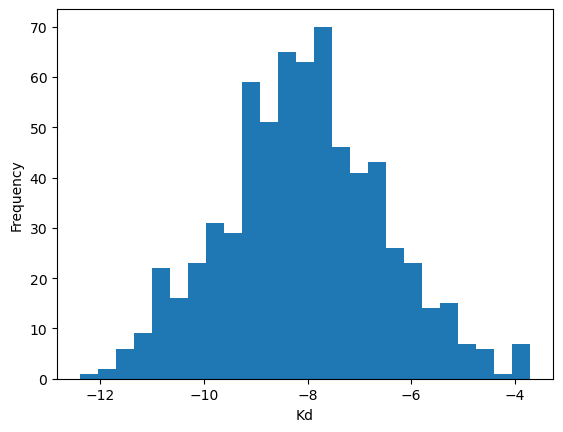

In [814]:
plt.hist(kds, 25)
plt.xlabel('Kd')
plt.ylabel('Frequency')
plt.show()

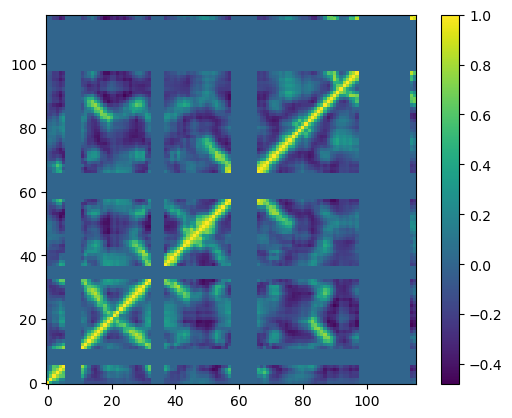

In [815]:
plt.imshow(train_x[74].reshape(train_x.shape[-1], train_x.shape[-1]), origin='lower')
plt.colorbar()

In [816]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.023, random_state=31)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((660, 116, 116), (660,)), ((16, 116, 116), (16,)))

In [817]:
# converting training images into torch format
train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], train_x.shape[1])
train_x = train_x.astype(np.float32)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(np.float32).reshape(train_y.shape[0], 1)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([660, 1, 116, 116]), torch.Size([660, 1]))

In [983]:
# converting validation images into torch format
val_x = val_x.reshape(val_x.shape[0], 1, train_x.shape[2], train_x.shape[2])
val_x = val_x.astype(np.float32)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(np.float32).reshape(val_y.shape[0], 1)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

AttributeError: 'Tensor' object has no attribute 'astype'

In [2826]:
n_filters = 3
filter_size = 5
pooling_size = 2
fully_connected_input = n_filters * ((train_x.shape[2] - filter_size + 1) // pooling_size) ** 2

class MultiLabelNN(Module):
    def __init__(self):
        super(MultiLabelNN, self).__init__()
        self.conv1 = Conv2d(1, n_filters, filter_size)
        #self.conv1.weight.data = self.conv1.weight.data#torch.tril(self.conv1.weight.data) + torch.transpose(torch.tril(self.conv1.weight.data), 2, 3)
        #self.conv1.weight.data.fill_(1e-5)
        self.pool = MaxPool2d(pooling_size, pooling_size)
        #self.conv2 = Conv2d(n_filters, n_filters, filter_size+2)
        #self.conv2.weight.data = torch.tril(self.conv2.weight.data) + torch.transpose(torch.tril(self.conv2.weight.data), 2, 3)
        #self.conv2.weight.data = torch.transpose(self.conv2.weight.data, 2, 3)
        self.relu = ReLU()
        self.fc1 = Linear(fully_connected_input, 1, bias=False)
        #self.fc2 = Linear(128, 1)
        self.dropit = Dropout(p=0.05)
        #self.fc3 = Linear(128, 64)
        #self.fc4 = Linear(64, 1)

    def forward(self, x):
       #shape of x is (b_s, 32,32,1)
        x = self.conv1(x) + torch.transpose(self.conv1(x), 2, 3)#shape of x is (b_s, 28,28,132)
        x = self.relu(x)
        x = self.pool(x) #shape of x now becomes (b_s X 14 x 14 x 32)
        #x = self.conv2(x) # shape(b_s, 10x10x64)
        inter = x = self.relu(x)#size is (b_s x 10 x 10 x 64)
        #inter = x
        x = x.view(x.size(0), -1) # shape of x is now(b_s*2, 3200)
        #this is the problem 
        #you can fc1 to be of shape (6400,1024) and that will work 
        x = self.dropit(x)
        x = self.fc1(x)
        #x = self.relu(x)
        #x = self.fc2(x)
        #x = self.relu(x)
        #x = self.fc3(x)
        #x = self.relu(x)
        #x = self.fc4(x)


        return x.float(), inter


In [2851]:
# defining the model
model = MultiLabelNN()
# defining the optimizer
#optimizer = Adam(model.parameters(), lr=2e-3)
#optimizer = AdamW(model.parameters(), lr=1.75e-3)
optimizer = AdaBelief(model.parameters(), lr=1e-3, eps=1e-8, weight_decouple=False) #1.55 for pool=2
#optimizer = SGD(model.parameters(), lr=9e-4)
#scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.5, total_iters=120, verbose=True)
# 0.5 120
# 0.25 181
# 0.125

# defining the loss function
criterion = MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Rectification enabled in AdaBelief
MultiLabelNN(
  (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool):

In [2852]:
train_x.size()[0]

660

In [3090]:
def train(epoch):
    model.train()
    tr_loss = 0
    batch_size = 32
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)

    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    inter_filter = np.zeros((x_train.size()[0], n_filters, 56, 56))
    
    
    permutation = torch.randperm(x_train.size()[0])
    #val_indices = torch.randperm(x_val.size()[0])[:1]

    for i in range(0, x_train.size()[0], batch_size):

        
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        
        # prediction for training and validation set
        output_train, inter_filters = model(batch_x)
        
        inter_filter[i:i+batch_size] = inter_filters.detach().numpy()

        # computing the training loss
        loss_train = torch.std(batch_y) * criterion(output_train, batch_y)

        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizer.step()
        
        loss_train /= torch.std(batch_y)
        
        # clearing the Gradients of the model parameters
        optimizer.zero_grad(set_to_none=True)
        
        tr_loss += loss_train.item() * batch_size / x_train.size()[0]
    output_val, _ = model(x_val)#[val_indices])
    loss_val = criterion(output_val, y_val)#[val_indices])
    train_losses.append(tr_loss)
    val_losses.append(loss_val)
    
    # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'train loss: ', tr_loss, 'val loss :', loss_val)
    print(output_val)
    print(y_val)#[val_indices])
        
    return tr_loss, loss_val, inter_filter, batch_y, y_val, output_val, permutation


In [2854]:
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

In [3162]:
for i in range(1):# defining the number of epochs
    n_max_epochs = 15

    # training the model
    for epoch in range(n_max_epochs):
        tr_loss, val_loss, inter_filter, y_tr, y_val, output_val, perm = train(epoch)
        #scheduler.step()
        if tr_loss < 0.67 and val_loss < 0.65 or val_loss < 0.5:
            break

Epoch :  1 	 train loss:  0.6393627412391433 val loss : tensor(0.7996, grad_fn=<MseLossBackward0>)
tensor([[-8.6938],
        [-8.2776],
        [-8.6895],
        [-9.7256],
        [-7.9594],
        [-6.8023],
        [-9.6949],
        [-9.3583],
        [-8.9967],
        [-6.4554],
        [-7.5426],
        [-7.9695],
        [-8.6692],
        [-7.6771],
        [-9.6013],
        [-7.0328]], grad_fn=<MmBackward0>)
tensor([[ -7.9586],
        [ -6.7905],
        [ -7.7959],
        [-11.3979],
        [ -8.4318],
        [ -6.9208],
        [ -7.7696],
        [ -9.3010],
        [ -8.8861],
        [ -6.0410],
        [ -8.5376],
        [ -7.6021],
        [ -8.1643],
        [ -7.6840],
        [ -9.7696],
        [ -6.0804]])
Epoch :  2 	 train loss:  0.682812144539573 val loss : tensor(0.9782, grad_fn=<MseLossBackward0>)
tensor([[-8.6692],
        [-8.2662],
        [-8.9786],
        [-9.5198],
        [-8.6144],
        [-6.8080],
        [-9.7376],
        [-9.5336],
  

In [3163]:
#optimizer = AdaBelief(model.parameters(), lr=8e-5, eps=1e-8, weight_decouple=False) # th 4e-4 and 8e-4
# 150 (scheduler from 3e-3 to 1.5e-3 in 120 ep), 150, ..., and finally 150 (lr=8e-4)

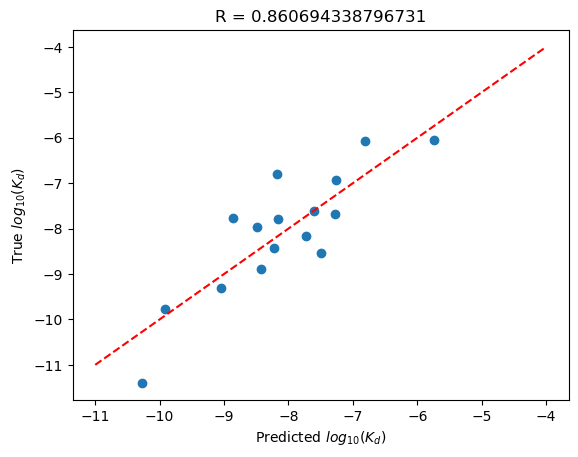

In [3164]:
plt.scatter(output_val.detach().numpy(), y_val.detach().numpy())
corr = np.corrcoef(output_val.detach().numpy().T, y_val.detach().numpy().T)[1,0]
plt.plot([-11,-4],[-11,-4], c='r', linestyle='dashed')
plt.title('R = '+str(corr))
plt.xlabel('Predicted $log_{10}$($K_d$)')
plt.ylabel('True $log_{10}$($K_d$)')
plt.show()

In [3165]:
size_le = int(np.sqrt(model.fc1.weight.data.numpy().shape[-1] / n_filters))
size_le

56

In [3166]:
inter_filter.shape

(660, 3, 56, 56)

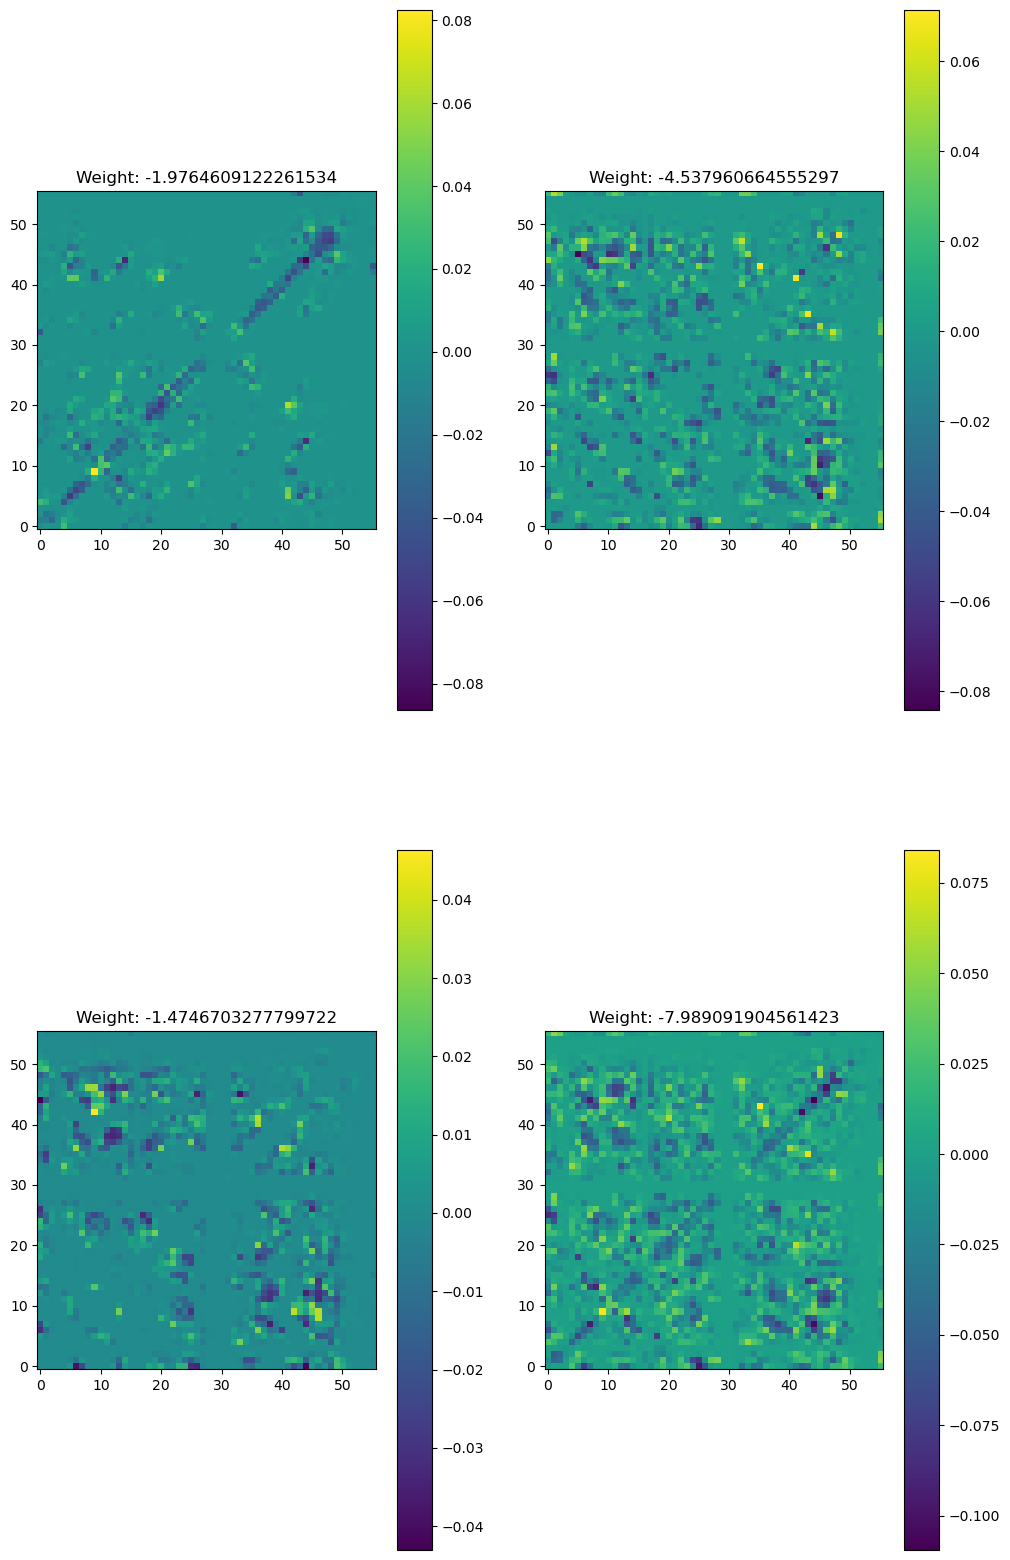

In [3167]:
import itertools

fig, axs = plt.subplots((n_filters+1)//2, 2, figsize=(12, 20))
img = np.zeros((size_le, size_le))

for i, j in itertools.product(range((n_filters+1)//2), range(2)):
    if j == 1 and i == (n_filters+1)//2-1 and n_filters % 2 != 0:
        im_ = img
    else:
        im_ = np.multiply(np.mean(inter_filter, axis=0)[2*i+j], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[2*i+j].reshape(size_le, size_le))
        img += im_
    im = axs[i,j].imshow(im_, origin='lower')
    plt.colorbar(im, ax=axs[i,j])
    axs[i,j].set_title('Weight: '+str(im_.sum()))

-7.989091904561423

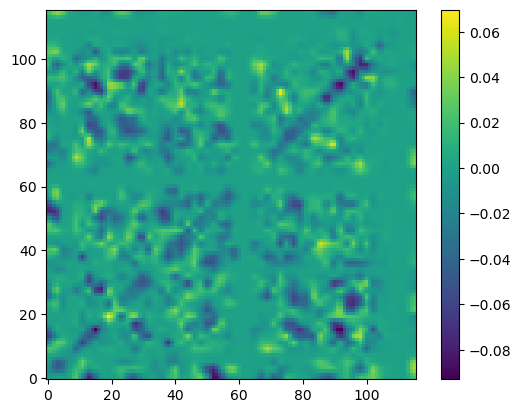

In [3168]:
plt.imshow(cv2.resize(img, dsize=(116, 116)), origin='lower')
plt.colorbar()
img.sum()

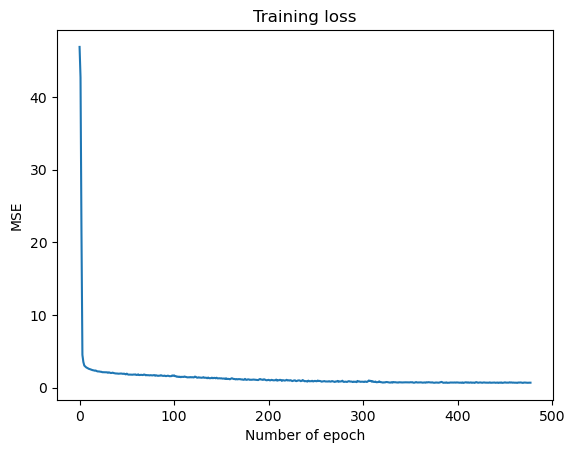

In [3169]:
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')
plt.show()

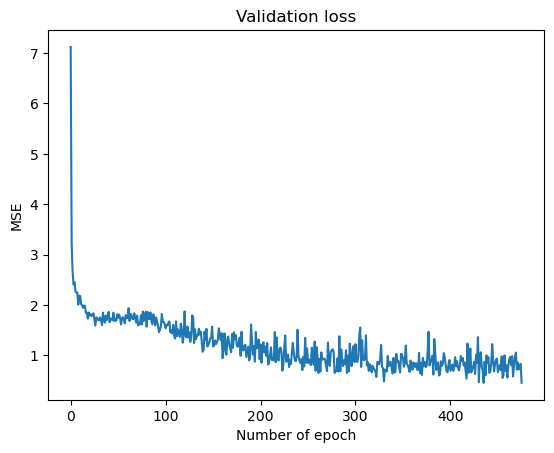

In [3170]:
plt.plot([val_losses[2:][i].detach().numpy() for i in range(len(val_losses[2:]))])
plt.title('Validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')
plt.show()

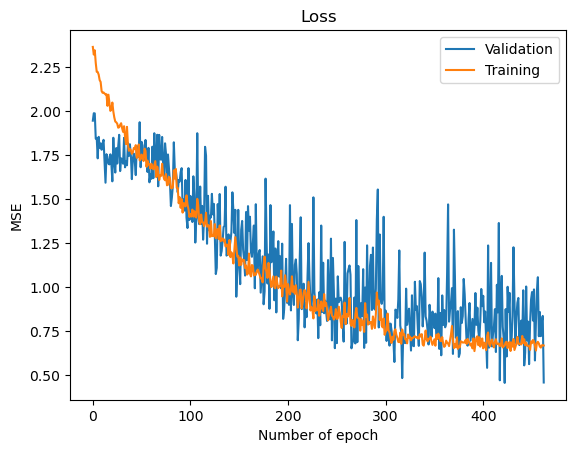

In [3171]:
plt.plot([val_losses[15:][i].detach().numpy() for i in range(len(val_losses[15:]))])
plt.plot([train_losses[15:][i] for i in range(len(train_losses[15:]))])
plt.title('Loss')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')
plt.legend(['Validation', 'Training'])
plt.show()

In [3172]:
model.eval()
model(Variable(train_x[40:80]))[0]

tensor([[ -7.7599],
        [ -8.0854],
        [ -9.3654],
        [ -8.2820],
        [ -7.1362],
        [ -5.6506],
        [ -7.7386],
        [-10.3541],
        [ -6.6262],
        [ -8.2601],
        [ -6.9271],
        [ -7.8937],
        [ -7.0957],
        [ -8.9728],
        [ -6.4946],
        [ -6.8769],
        [ -8.2274],
        [ -8.9487],
        [-10.4808],
        [ -8.3773],
        [ -4.2864],
        [ -7.1159],
        [ -8.0893],
        [ -9.1549],
        [ -8.8218],
        [ -6.5039],
        [ -7.2647],
        [-10.4172],
        [ -9.3563],
        [ -7.7599],
        [ -7.7787],
        [ -6.5928],
        [ -7.6652],
        [ -8.7545],
        [ -6.7395],
        [ -6.6569],
        [ -8.3444],
        [ -5.7965],
        [ -6.4981],
        [ -7.4417]], grad_fn=<MmBackward0>)

In [3173]:
Variable(train_y[40:80])

tensor([[ -7.7212],
        [ -7.8539],
        [ -8.3872],
        [ -9.1267],
        [ -7.3665],
        [ -5.4685],
        [ -7.9208],
        [-10.5452],
        [ -5.9747],
        [ -8.6576],
        [ -7.3565],
        [ -8.7645],
        [ -6.5229],
        [ -8.4318],
        [ -6.1024],
        [ -6.5086],
        [ -8.5376],
        [ -9.9393],
        [-11.3979],
        [ -8.4473],
        [ -4.7959],
        [ -5.8327],
        [ -8.2218],
        [ -9.7375],
        [ -9.0362],
        [ -6.3615],
        [ -8.1463],
        [-10.6990],
        [ -9.3010],
        [ -7.7212],
        [ -8.0605],
        [ -6.2840],
        [ -7.9586],
        [ -9.0000],
        [ -5.5686],
        [ -6.0794],
        [-11.5229],
        [ -6.0458],
        [ -6.6990],
        [ -7.4685]])

In [3103]:
file_paths

['/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1a4k.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1aj7.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1axs.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1bj1.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1bvk.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1c12.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1c5c.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1ct8.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1cz8.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1d6v.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dbb.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dee.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dl7.npy',
 '/Users/kevinmicha/Docum

In [3104]:
entry = '1t66'
download_path = '/Users/kevinmicha/Downloads/'
file_name = entry + numbering + selection
path = folder + file_name + file_type_input
new_path = download_path + entry + '_map'
generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input, lresidues=False)  
subprocess.call(['/usr/local/bin/RScript pdb_to_dccm.r ' + str(path) + ' ' + str(new_path) + ' ' + str(modes)], shell=True, stdout=open(os.devnull, 'wb'))#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))
subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))

if os.path.exists(path):
    os.remove(path)
h, l = np.load(download_path + 'value.npy') 

In [3105]:
f = download_path + entry + '_map' + '.npy'
res_path = np.array([download_path + entry + '_residues' + '.npy'])
test_array, mask = generate_masked_image(np.load(f), idx=0, res_list=max_res_list, file_residues_paths=res_path, mode='fully-extended')
test_sample = torch.from_numpy(test_array.reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32))

In [3106]:
# this value should be in the -7 to -4 interval
model.eval()
model(test_sample)[0]

tensor([[-5.6895]], grad_fn=<MmBackward0>)

In [3107]:
prediction = 10**model(test_sample)[0].detach().numpy()
prediction

array([[2.044223e-06]], dtype=float32)

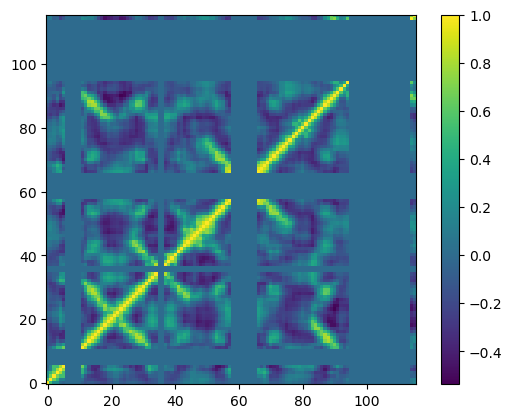

In [3009]:
plt.imshow(test_array, origin='lower')
plt.colorbar()

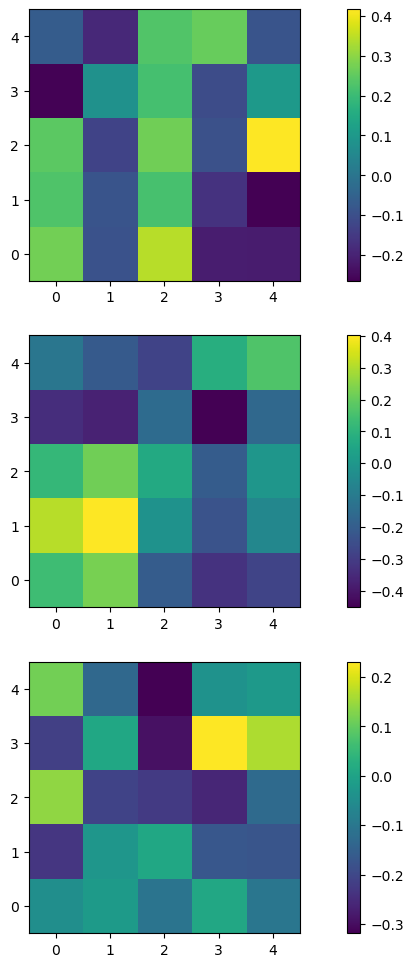

In [3010]:
import itertools

fig, axs = plt.subplots(n_filters, 1, figsize=(12, 12))
conv_filters = deepcopy(model.conv1.weight.data.numpy())
                           
for i, j in itertools.product(range(n_filters), range(1)):
    im = axs[i].imshow(conv_filters[i+j][0], origin='lower')
    #axs[i].set_xticks([0, 6.25, 20], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    #axs[i].set_yticks([0, 6.25, 20], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])

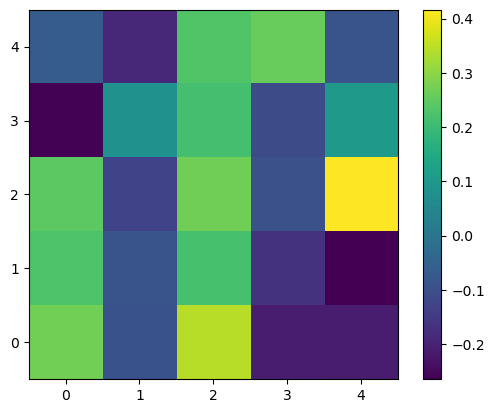

In [3011]:
plt.imshow(np.mean(conv_filters[0,...], axis=0), origin='lower')
plt.colorbar()

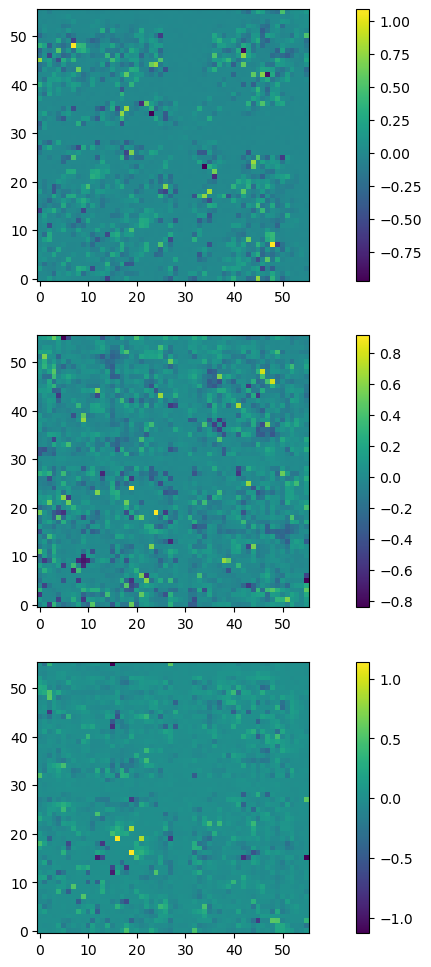

In [3012]:
fig, axs = plt.subplots(n_filters, 1, figsize=(12, 12))

fully_connected = deepcopy(model.fc1.weight.data.numpy().reshape(n_filters, size_le**2))
#fully_connected = np.where(abs(fully_connected)<0.05, 0, fully_connected)

for i, j in itertools.product(range(n_filters), range(1)):
    im = axs[i].imshow(fully_connected[i].reshape(size_le, size_le), origin='lower')
    #axs[i].set_xticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    #axs[i].set_yticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])


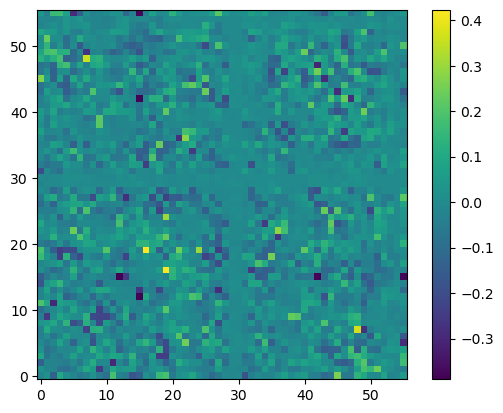

In [3013]:
plt.imshow(np.mean(fully_connected.reshape(n_filters, size_le, size_le), axis=0), origin='lower')
plt.colorbar()

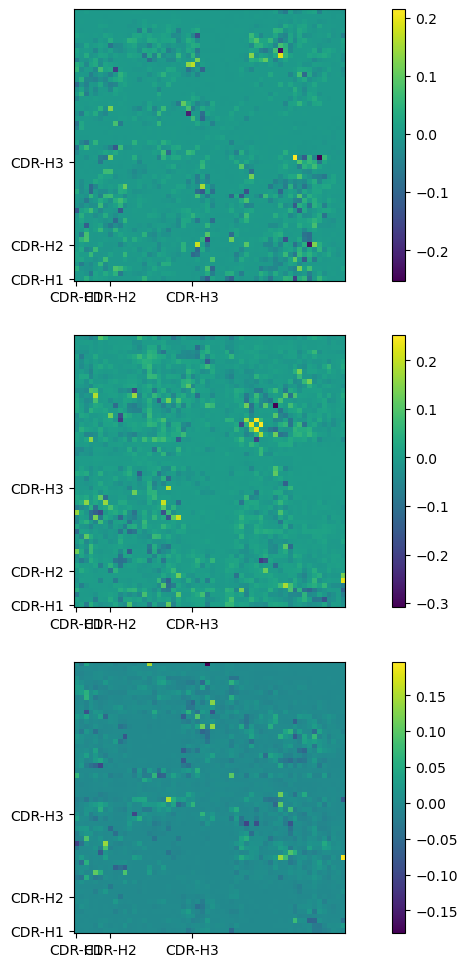

In [3014]:
fig, axs = plt.subplots(n_filters, 1, figsize=(12, 12))

imgg = np.zeros((size_le, size_le))
for i, j in itertools.product(range(n_filters), range(1)):
    conv_bank = cv2.resize(conv_filters[i,0,...], dsize=(size_le, size_le), interpolation=cv2.INTER_AREA)
    #new_img = np.multiply(np.where(conv_bank<-3,0,conv_bank), fully_connected[i].reshape(15, 15)) 
    new_img = np.multiply(conv_bank, fully_connected[i].reshape(size_le, size_le)) #+ model.fc1.bias.data.numpy()
    im = axs[i].imshow(new_img, origin='lower')
    axs[i].set_xticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    axs[i].set_yticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])
    imgg += new_img

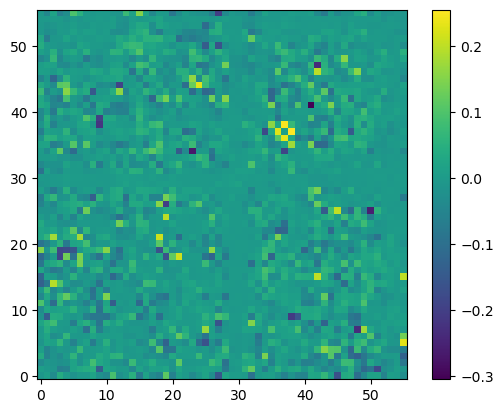

In [3015]:
#blue = "need blue in dccm"
#yellow = "need red in dccm"
plt.imshow(np.where(abs(imgg)<0.002, 0, imgg), origin='lower')
plt.colorbar()
plt.show()

In [3016]:
imgg.sum()

2.1482176818092213

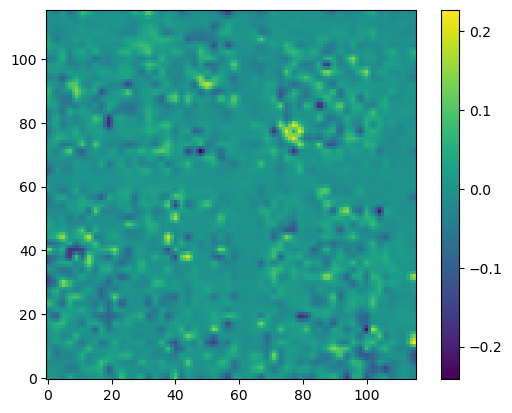

In [3017]:
plt.imshow(cv2.resize(imgg, dsize=(train_x.shape[2], train_x.shape[2])), origin='lower')
plt.colorbar()

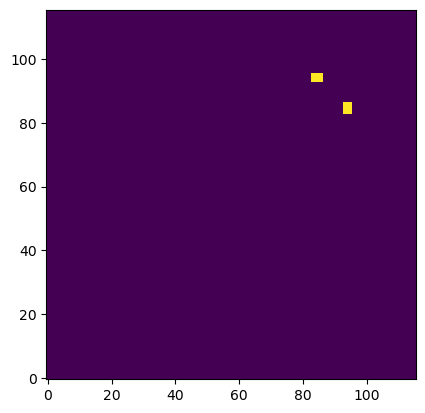

In [3018]:
#Arbitrary mask analysis
test_mask = np.zeros((train_x.shape[2], train_x.shape[2]))
test_mask[93:96, 83:87] = 1
test_mask += np.transpose(test_mask)
plt.imshow(test_mask, origin='lower')

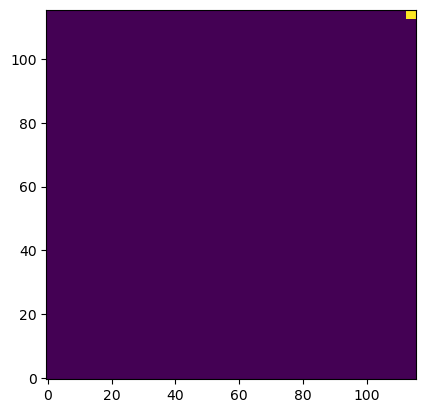

In [3019]:
#CDR-H3 analysis
cdr3_mask = np.zeros((train_x.shape[2], train_x.shape[2]))
cdr3_mask[-3:, -3:] = 1
plt.imshow(cdr3_mask, origin='lower')

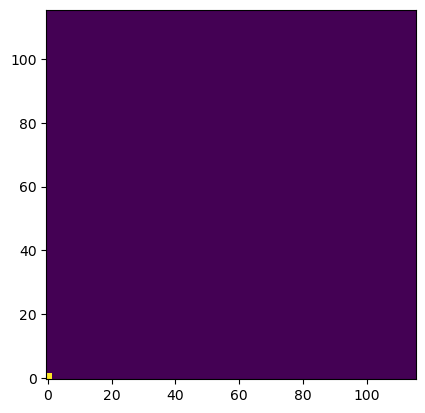

In [3020]:
#CDR-H1 analysis
cdr1_mask = np.zeros((train_x.shape[2], train_x.shape[2]))
cdr1_mask[:2, :2] = 1
plt.imshow(cdr1_mask, origin='lower')

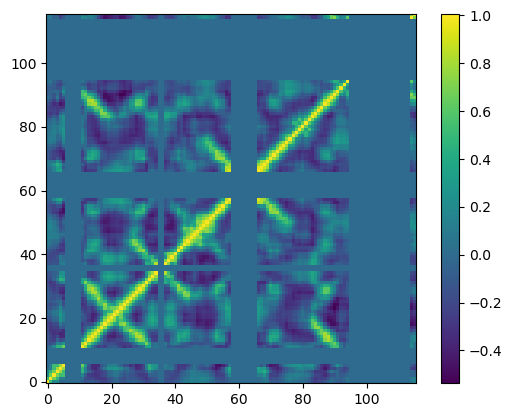

In [3021]:
img_factor = 0.1
cdr3_factor = 0
cdr1_factor = 0
test_factor = 0


ideal = test_array + np.multiply(mask, img_factor * cv2.resize(img, dsize=(train_x.shape[2], train_x.shape[2])) + cdr3_factor * cdr3_mask  + cdr1_factor * cdr1_mask + test_factor * test_mask)
plt.imshow(ideal, origin='lower')
plt.colorbar()

In [3022]:
model.eval()
new_prediction = 10**model(torch.from_numpy(ideal.reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32)))[0].detach().numpy()
per_change = ((prediction - new_prediction) / prediction * 100)[0][0]
print(new_prediction)
print('Adding/subtracting the obtained map with a factor of', img_factor, 'makes Kd smaller by', per_change, '%')

[[1.8468589e-06]]
Adding/subtracting the obtained map with a factor of 0.1 makes Kd smaller by 22.711067 %


In [3023]:
high_aff = []
low_aff = []

for i in range(train_y.detach().numpy().shape[0]):
    if train_y.detach().numpy()[i][0] < -8:
        high_aff.append(train_x.detach().numpy()[i])
    elif train_y.detach().numpy()[i][0] > -6:
        low_aff.append(train_x.detach().numpy()[i])
        
mean_image = np.mean(train_x.detach().numpy(), axis=0).reshape(train_x.shape[-1], train_x.shape[-1])
mask_mean_image = -1 * np.sign(mean_image) 
mean_diff_image = np.median(high_aff, axis=0)-np.median(low_aff, axis=0)

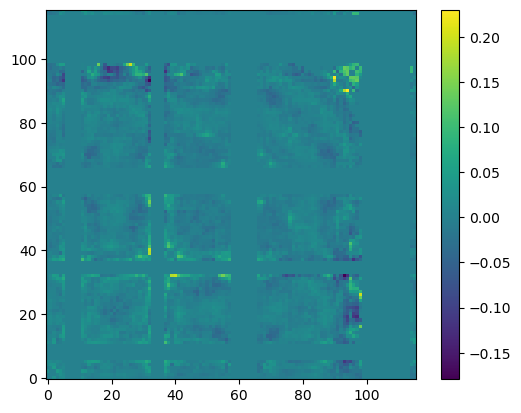

In [3024]:
plt.imshow(mean_diff_image[0], origin='lower')
plt.colorbar()

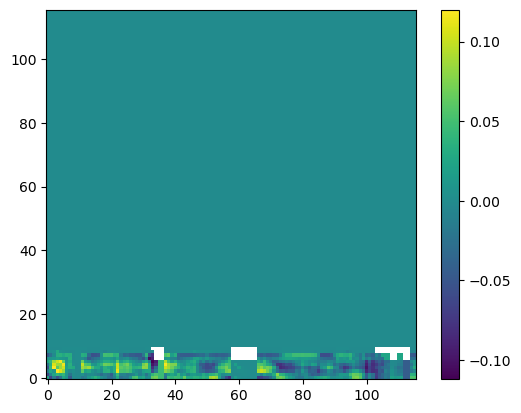

In [3025]:
plt.imshow(corr_matrix.reshape(116, 116), origin='lower')
plt.colorbar()

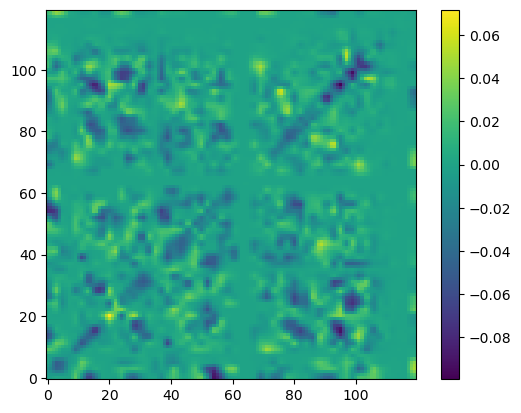

In [3026]:
plt.imshow(cv2.resize(img, dsize=(120, 120)), origin='lower')
plt.colorbar()

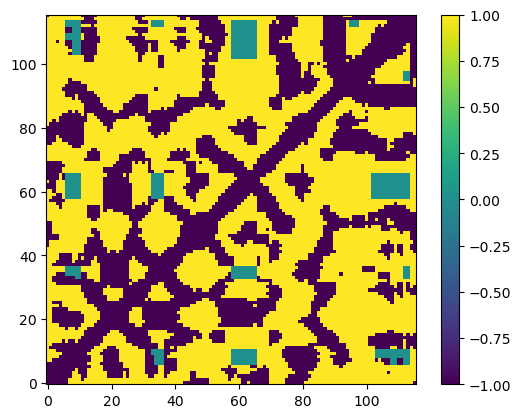

In [3027]:
plt.imshow(mask_mean_image, origin='lower')
plt.colorbar()

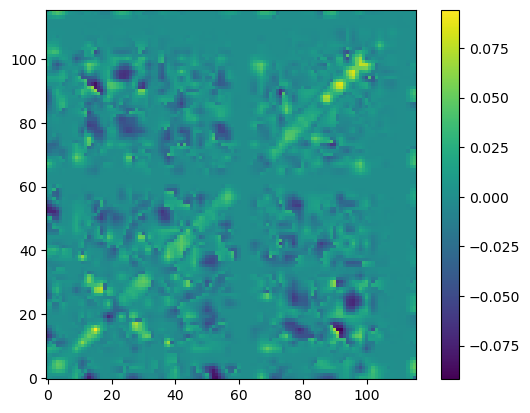

In [3028]:
plt.imshow(np.multiply(cv2.resize(img, dsize=(116, 116)), mask_mean_image), origin='lower')
plt.colorbar()

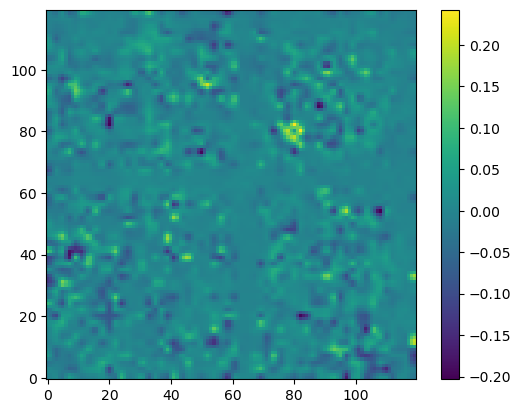

In [3029]:
plt.imshow(cv2.resize(imgg, dsize=(120, 120)), origin='lower')
plt.colorbar()

In [3030]:
cdr1_coord = range(max_res_list.index('26'), max_res_list.index('33'))
cdr2_coord = range(max_res_list.index('52'), max_res_list.index('57'))
cdr3_coord = range(max_res_list.index('95'), max_res_list.index('102')+1)
beta11_coord = range(max_res_list.index('33'), max_res_list.index('39'))
beta12_coord = range(max_res_list.index('45'), max_res_list.index('51'))
beta13_coord = range(max_res_list.index('57'), max_res_list.index('61'))
beta14_coord = range(max_res_list.index('89'), max_res_list.index('95'))
beta21_coord = range(max_res_list.index('67'), max_res_list.index('72'))
beta22_coord = range(max_res_list.index('75'), max_res_list.index('82'))
alpha_coord = range(max_res_list.index('84'), max_res_list.index('87'))

masked_img = np.multiply(cv2.resize(img, dsize=(116, 116)), mask_mean_image)
#masked_img = np.multiply(cv2.resize((img-img.max())/(img.min()-img.max()), dsize=(116, 116)), mean_diff_image)
#masked_img = cv2.resize(img, dsize=(116, 116))
#masked_img = mean_diff_image
#masked_img = corr_matrix.reshape(116, 116)

ticks = [cdr1_coord[0], (cdr1_coord[-1]+beta11_coord[0])/2, beta11_coord[-1], beta12_coord[0], beta12_coord[-1], cdr2_coord[0], (cdr2_coord[-1]+beta13_coord[0])/2, beta13_coord[-1], beta21_coord[0], beta21_coord[-1],
         beta22_coord[0], beta22_coord[-1], beta14_coord[0], (beta14_coord[-1]+cdr3_coord[0])/2, cdr3_coord[-1]]

ticks_labels = ['CDR-H1_i', 'CDR-H1_f & Beta11_i', 'Beta11_f', 'Beta12_i', 'Beta12_f', 'CDR-H2_i', 'CDR-H2_f & Beta13_i', 'Beta13_f', 'Beta21_i', 'Beta21_f', 'Beta22_i', 'Beta22_f', 'Beta14_i', 'Beta14_f & CDR-H3_i', 'CDR-H3_f']

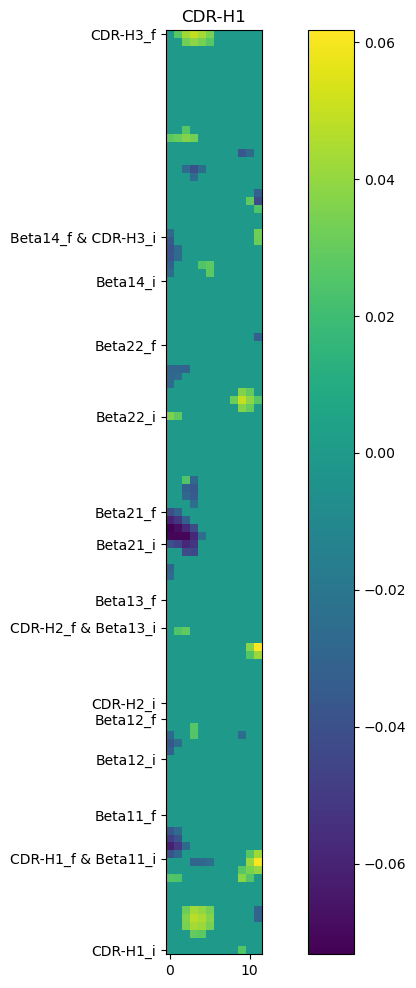

2.0838917310121343


In [3031]:
plt.figure(figsize=(12, 12))
cdr1_corr = masked_img[:, cdr1_coord]
plt.imshow(np.where(abs(cdr1_corr)<abs(cdr1_corr).max()/3, 0, cdr1_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('CDR-H1')
plt.show()
print(abs(cdr1_corr).sum()/6)

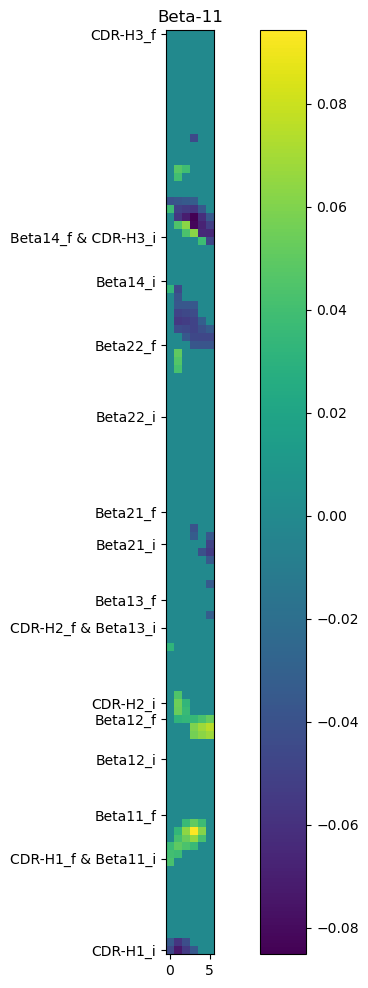

1.9877714587766797


In [3032]:
plt.figure(figsize=(12, 12))
beta11_corr = masked_img[:, beta11_coord]
plt.imshow(np.where(abs(beta11_corr)<abs(beta11_corr).max()/3, 0, beta11_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-11')
plt.show()
print(abs(beta11_corr).sum()/5)

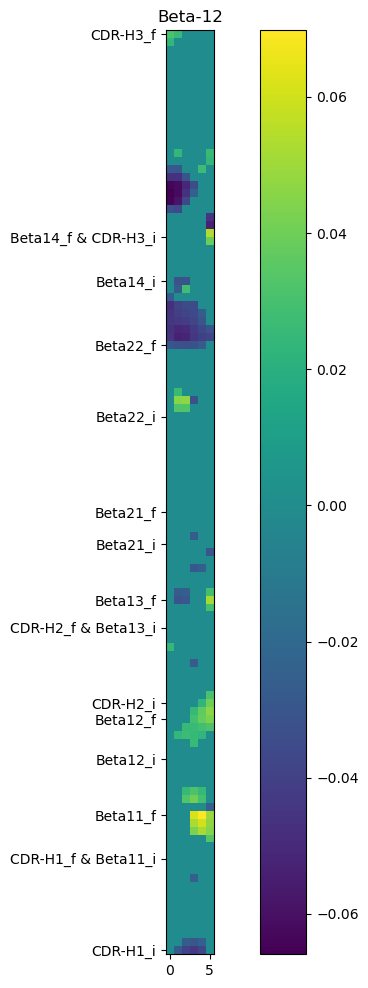

1.8016243170156734


In [3033]:
plt.figure(figsize=(12, 12))
beta12_corr = masked_img[:, beta12_coord]
plt.imshow(np.where(abs(beta12_corr)<abs(beta12_corr).max()/3, 0, beta12_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-12')
plt.show()
print(abs(beta12_corr).sum()/5)

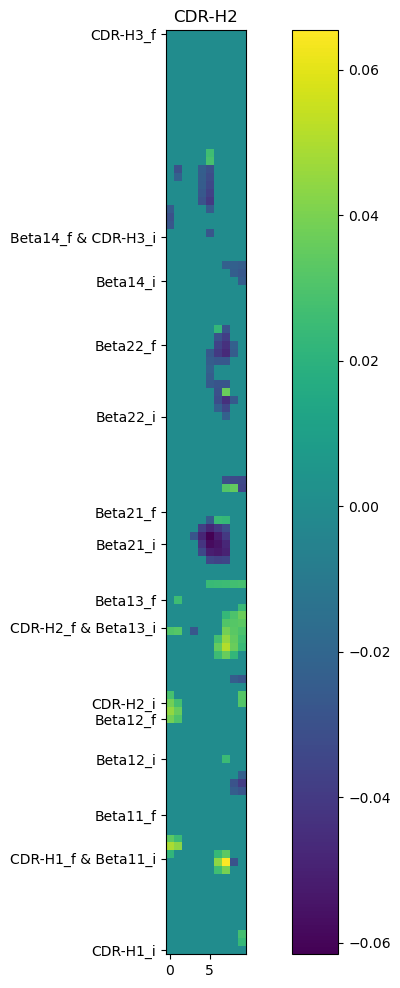

2.743871684258225


In [3034]:
plt.figure(figsize=(12, 12))
cdr2_corr = masked_img[:, cdr2_coord]
plt.imshow(np.where(abs(cdr2_corr)<abs(cdr2_corr).max()/3, 0, cdr2_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('CDR-H2')
plt.show()
print(abs(cdr2_corr).sum()/4)

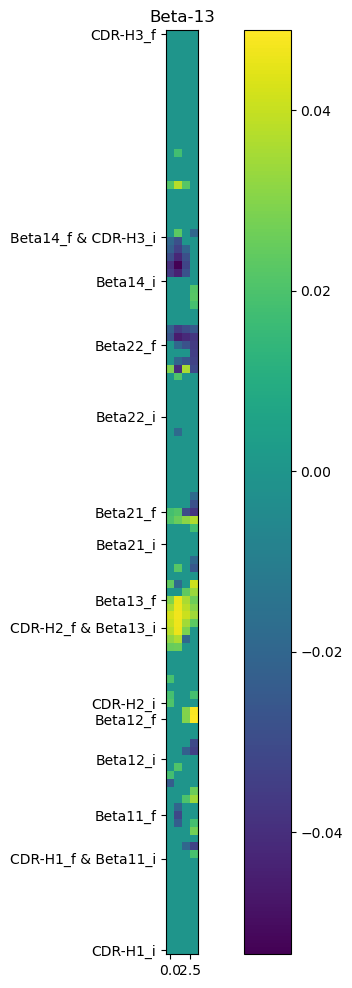

1.8102434579005717


In [3035]:
plt.figure(figsize=(12, 12))
beta13_corr = masked_img[:, beta13_coord]
plt.imshow(np.where(abs(beta13_corr)<abs(beta13_corr).max()/3, 0, beta13_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-13')
plt.show()
print(abs(beta13_corr).sum()/3)

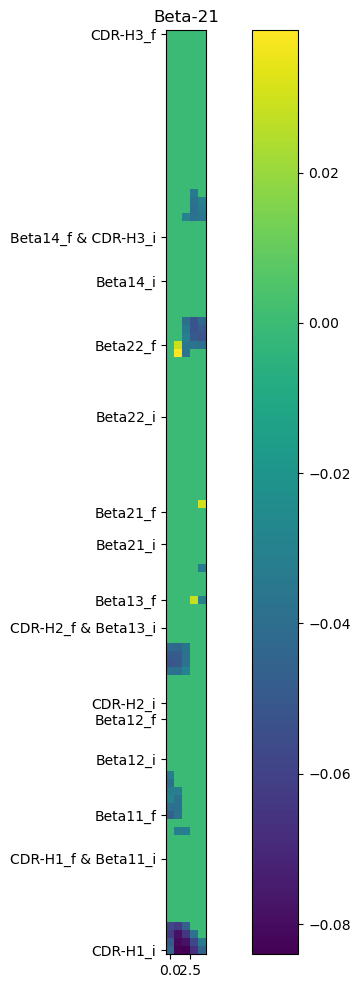

1.7683743915952717


In [3036]:
plt.figure(figsize=(12, 12))
beta21_corr = masked_img[:, beta21_coord]
plt.imshow(np.where(abs(beta21_corr)<abs(beta21_corr).max()/3, 0, beta21_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-21')
plt.show()
print(abs(beta21_corr).sum()/4)

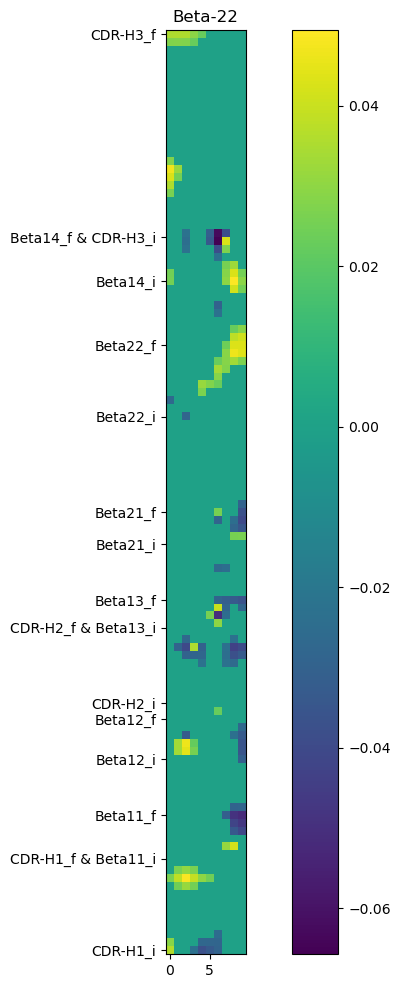

1.9014012173451365


In [3037]:
plt.figure(figsize=(12, 12))
beta22_corr = masked_img[:, beta22_coord]
plt.imshow(np.where(abs(beta22_corr)<abs(beta22_corr).max()/3, 0, beta22_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-22')
plt.show()
print(abs(beta22_corr).sum()/6)

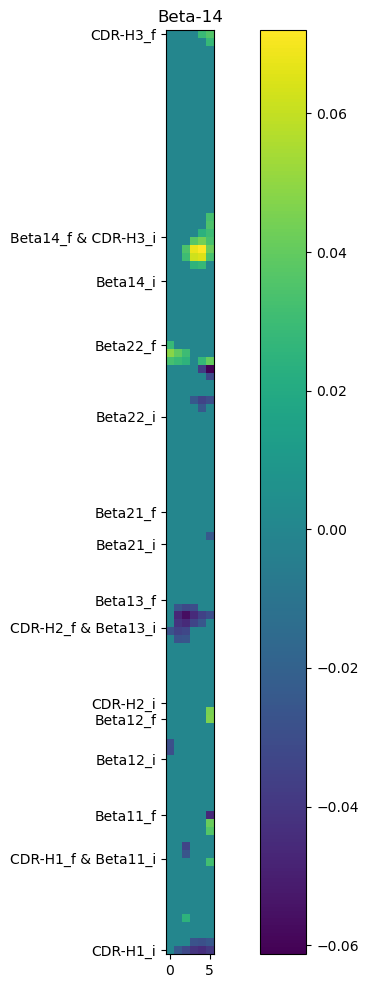

1.4451124897796523


In [3038]:
plt.figure(figsize=(12, 12))
beta14_corr = masked_img[:, beta14_coord]
plt.imshow(np.where(abs(beta14_corr)<abs(beta14_corr).max()/3, 0, beta14_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-14')
plt.show()
print(abs(beta14_corr).sum()/5)

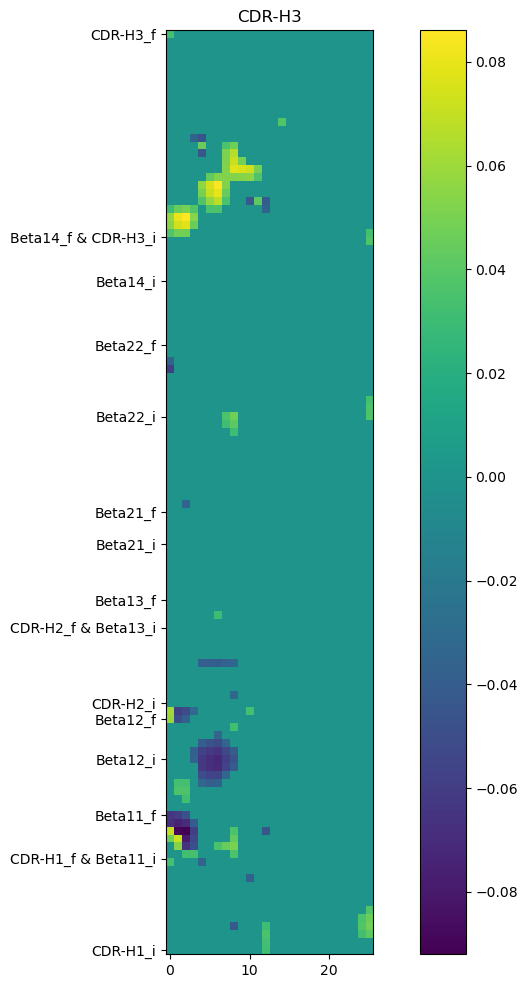

3.251949548236781


In [3039]:
plt.figure(figsize=(12, 12))
cdr3_corr = masked_img[:, cdr3_coord]
plt.imshow(np.where(abs(cdr3_corr)<abs(cdr3_corr).max()/3, 0, cdr3_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('CDR-H3')
plt.show()
print(abs(cdr3_corr).sum()/7)

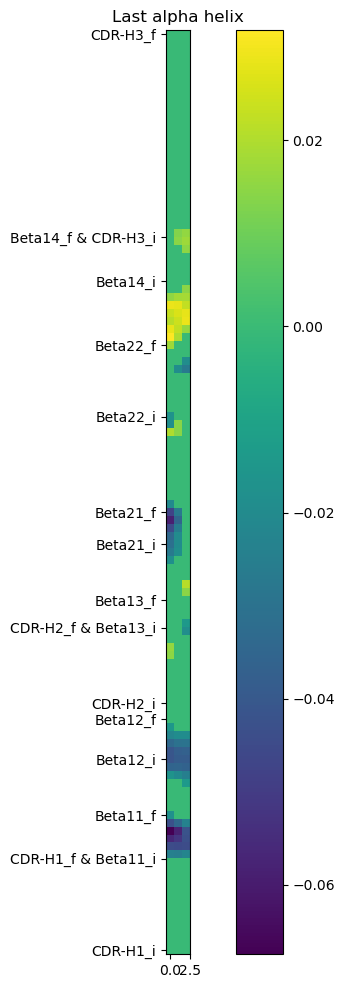

1.6725163929310256


In [3040]:
plt.figure(figsize=(12, 12))
alpha_corr = masked_img[:, alpha_coord]
plt.imshow(np.where(abs(alpha_corr)<abs(alpha_corr).max()/5, 0, alpha_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Last alpha helix')
plt.show()
print(abs(alpha_corr).sum()/2)

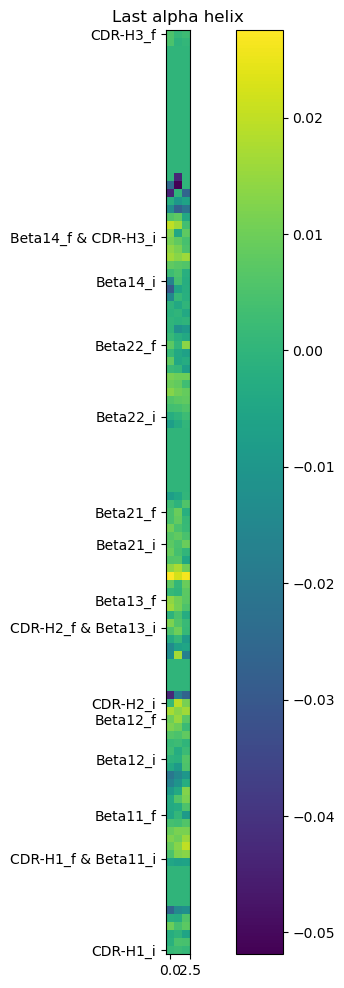

1.9915164


In [3041]:
plt.figure(figsize=(12, 12))
alpha_corr_diff = mean_diff_image[0][:, alpha_coord]
plt.imshow(alpha_corr_diff, origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Last alpha helix')
plt.show()
print(abs(alpha_corr_diff).sum())#/alpha_corr.shape[1])

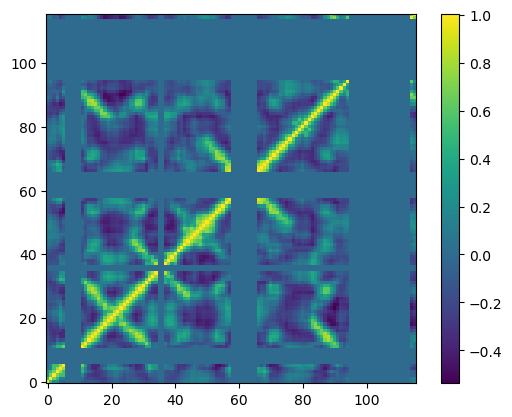

In [3042]:
# expanded version
cdr3_factor = 0.05
cdr1_factor = 0.05
cdr2_factor = 0.05
beta11_factor = 0.05 
beta12_factor = 0.05
beta13_factor = 0.05 
beta14_factor = 0.05 
beta21_factor = 0.05 
beta22_factor = 0.05
alpha_factor = 0.05

weights = np.array([cdr1_factor, beta11_factor, beta12_factor, cdr2_factor, beta13_factor, beta21_factor, beta22_factor, alpha_factor, beta14_factor, cdr3_factor])
coord = np.array([cdr1_coord, beta11_coord, beta12_coord, cdr2_coord, beta13_coord, beta21_coord, beta22_coord, alpha_coord, beta14_coord, cdr3_coord], dtype=object)
maps = [cdr1_corr, beta11_corr, beta12_corr, cdr2_corr, beta13_corr, beta21_corr, beta22_corr, alpha_corr, beta14_corr, cdr3_corr]

ideal = deepcopy(test_array)

for i in range(len(weights)):
    temp = np.pad(maps[i], ((0, 0), (coord[i][0], train_x.shape[2]-coord[i][-1]-1)))
    ideal += np.multiply(mask, weights[i] * (temp + np.transpose(temp)) / 2) 
    #ideal += weights[i] * (temp + np.transpose(temp)) / 2
plt.imshow(ideal, origin='lower')
plt.colorbar()


In [3043]:
model.eval()
new_prediction = 10**model(torch.from_numpy(ideal.reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32)))[0].detach().numpy()
per_change = ((prediction - new_prediction) / prediction * 100)[0][0]
print(new_prediction)
print('Kd smaller by', per_change, '%')

[[1.8369898e-06]]
Kd smaller by 23.124079 %


### Finding correlations between actual strucutres

In [3174]:
inter_filter.shape

(660, 3, 56, 56)

In [3175]:
each_img = np.zeros((train_x.shape[0], inter_filter.shape[2], inter_filter.shape[3]))
each_img_enl = np.zeros((train_x.shape[0], train_x.shape[2], train_x.shape[3]))


for j in range(train_x.shape[0]):
    for i in range(n_filters):
        each_img[j] += np.multiply(inter_filter[j,i], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[i].reshape(size_le, size_le))
        each_img_enl[j] += cv2.resize(np.multiply(inter_filter[j,i], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[i].reshape(size_le, size_le)), dsize=(116,116))

0.2325817590296927
0.23301676911218042
0.23261369363675968
0.23304409469251552
0.23253488167294292
0.23261656400895103
0.23322951396003427
0.2328300008040633
0.23273169157300358
0.23303453942860883
0.2329943278073107
0.23331173366885322
0.2329556528866259
0.2333542600280323
0.23300615561644045
0.2331168110114974
0.2329229833510256
0.23327630059705587
0.23298095257134116
0.23327928069165477
0.23280031611536123
0.23316927369892343
0.2331404825755107
0.23307288959567307
0.23321802673358474
0.23288122506179715
0.23333916602744315
0.23292560056228798
0.232929381881013
0.23331700006646786
0.2330824953922716
0.23237805365661712
0.23307038184371606
0.23315412449329445
0.23320622969010113
0.23269319073202047
0.23300624090267297
0.2330937014548197
0.2334004155187852
0.23272552196304336
0.23296408851116632
0.23399078583415267
0.23330159192005331
0.23314664428130139
0.23297010057408798
0.2324291522091576
0.23291265422291277
0.23302475169550005
0.23283638375586088
0.23306305059604843
0.233120695998

0.23306397204547571
0.23307224254776815
0.23313807361122962
0.23321579491315444
0.2332318062008045
0.2332684671014036
0.23320002684830257
0.23295892660345482
0.23307308706085778
0.23320872909620752
0.2332091479097029
0.23318396437335764
0.23303481253644506
0.2332464894774855
0.23273810462596628
0.23294901669316515
0.23298907758716753
0.23302675319132707
0.2331676923139682
0.23312359397096263
0.23296617794848912
0.23299862460648058
0.23315263333615194
0.23260117085777043
0.23323659785591255
0.2326358139824222
0.23282005142455292
0.23271915924607264
0.23302786554395555
0.23314864506135022
0.23233788621470272
0.23234125944334022
0.2327292990291662
0.23314471753090693
0.23291931361360416
0.23317226899045995
0.23280314041303976
0.232347665966593
0.23304547095320405
0.23302643913722731
0.23315778111540436
0.23310477688568235
0.23331244383284064
0.23302123160403915
0.23278039345345328
0.2333551283483204
0.2333774245292033
0.23249883452503387
0.23285927524674643
0.2332291853694596
0.2330943814

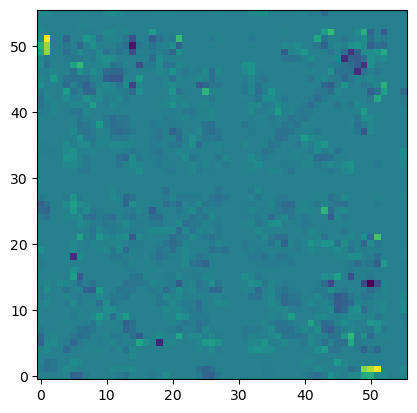

In [3046]:
cont = 0
for sample in range(660):
    plt.imshow(each_img[sample], origin='lower')
    #plt.colorbar()
    print(each_img[sample].sum()/each_img_enl[sample].sum())
        

In [3176]:
perm.detach().numpy()

array([294, 602, 644, 642, 137, 533,  63, 422, 238, 168, 276,  43, 229,
        65, 170, 564, 590, 520,  36, 655, 534, 110,  45, 104, 526, 194,
        74, 328,  53, 288,  15, 528,  33,  34, 275,  72,  80, 387, 565,
       606, 593, 637, 518, 613,  21, 363, 198, 496, 191, 259, 224, 211,
       575, 181, 240, 109, 322, 307, 556,  93, 448, 264,  35,  37, 559,
       631, 623, 473, 408, 446, 492, 324, 551, 323, 243,  47, 338, 239,
       287, 536, 235, 410, 633, 257, 160, 369, 538, 123, 652, 382, 370,
       480, 148, 163, 531, 334,  44, 165, 415, 563, 471, 552, 653, 474,
       390, 500, 122, 384, 427, 138, 348, 128, 646, 476, 337, 102, 548,
       393, 371, 527, 591, 236, 489,  14, 505, 513,  76, 570,  55, 143,
       501, 392, 625, 357, 186, 254,  62, 418, 656, 650, 443, 355, 557,
       156,  22, 106, 226, 440, 152, 469,  24, 632, 360,  58, 434, 452,
       246, 539, 615, 586, 535, 502,  39, 604, 255, 612, 525, 201, 609,
       624,  11, 300, 424, 117, 516, 543, 205, 562, 416, 487, 44

In [3177]:
enumerate(list(perm.detach().numpy()))

In [1672]:
# Get matrix with pixel values according to importance for Kd
corr_matrix = np.zeros((116**2))
for k in range(116**2):
    alpha_beta_vec = []
    s_kds = []
    for j, i in enumerate(list(perm.detach().numpy())):
        pix_val = imgs[i].reshape(116**2)[k]
        alpha_beta_vec.append(pix_val.sum())
        s_kds.append(train_y[i,:][0].detach().numpy())
    print(k)
    corr_matrix[k] = np.corrcoef(alpha_beta_vec, s_kds)[1,0]
corr_matrix = np.nan_to_num(corr_matrix, copy=True, nan=0.0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

KeyboardInterrupt: 

In [3178]:
len(range(cdr3_coord[0]-2,cdr3_coord[-1]+1))

28

In [3195]:
faulty = []
alpha_beta_vec = []
s_kds = []
img1 = imgs
#img2 = np.repeat(masked_img, train_x.shape[0]).reshape(train_x.shape[0], train_x.shape[2], train_x.shape[3])
img2 = each_img_enl

for j, i in enumerate(list(perm.detach().numpy())):
    img1[i] = np.multiply(mask, img1[i])
    #alpha_beta = np.convolve(imgs[i][:,alpha_coord].reshape(116*len(alpha_coord)), masked_img[:,alpha_coord].reshape(116*len(alpha_coord)))
    #alpha_beta = (corr_matrix[:,alpha_coord]).reshape(116*len(alpha_coord))#, each_img_enl[j][:, alpha_coord].reshape(116*len(alpha_coord)))
    alpha_beta = np.convolve(img1[i][:,range(alpha_coord[0]-2,alpha_coord[-1]+3)].reshape(116*(len(alpha_coord)+4)), img2[j][:,range(alpha_coord[0]-2,alpha_coord[-1]+3)].reshape(116*(len(alpha_coord)+4)))
    cdr3_beta = np.convolve(img1[i][:,range(cdr3_coord[0]-2,cdr3_coord[0]+10)].reshape(116*12), img2[j][:,range(cdr3_coord[0]-2,cdr3_coord[0]+10)].reshape(116*12))
    cdr2_beta = np.convolve(img1[i][:,range(cdr2_coord[0]-2,cdr2_coord[-1]+3)].reshape(116*(len(cdr2_coord)+4)), img2[j][:,range(cdr2_coord[0]-2,cdr2_coord[-1]+3)].reshape(116*(len(cdr2_coord)+4)))
    cdr1_beta = np.convolve(img1[i][:,range(cdr1_coord[0],cdr1_coord[-1]+3)].reshape(116*(len(cdr1_coord)+2)), img2[j][:,range(cdr1_coord[0],cdr1_coord[-1]+3)].reshape(116*(len(cdr1_coord)+2)))
    beta11_beta = np.convolve(img1[i][:,range(beta11_coord[0],beta11_coord[-1]+3)].reshape(116*(len(beta11_coord)+2)), img2[j][:,range(beta11_coord[0],beta11_coord[-1]+3)].reshape(116*(len(beta11_coord)+2)))
    beta12_beta = np.convolve(img1[i][:,range(beta12_coord[0],beta12_coord[-1]+3)].reshape(116*(len(beta12_coord)+2)), img2[j][:,range(beta12_coord[0],beta12_coord[-1]+3)].reshape(116*(len(beta12_coord)+2)))
    beta13_beta = np.convolve(img1[i][:,range(beta13_coord[0],beta13_coord[-1]+3)].reshape(116*(len(beta13_coord)+2)), img2[j][:,range(beta13_coord[0],beta13_coord[-1]+3)].reshape(116*(len(beta13_coord)+2)))
    beta14_beta = np.convolve(img1[i][:,range(beta14_coord[0],beta14_coord[-1]+3)].reshape(116*(len(beta14_coord)+2)), img2[j][:,range(beta14_coord[0],beta14_coord[-1]+3)].reshape(116*(len(beta14_coord)+2)))
    beta21_beta = np.convolve(img1[i][:,range(beta21_coord[0],beta21_coord[-1]+3)].reshape(116*(len(beta21_coord)+2)), img2[j][:,range(beta21_coord[0],beta21_coord[-1]+3)].reshape(116*(len(beta21_coord)+2)))
    beta22_beta = np.convolve(img1[i][:,range(beta22_coord[0],beta22_coord[-1]+3)].reshape(116*(len(beta22_coord)+2)), img2[j][:,range(beta22_coord[0],beta22_coord[-1]+3)].reshape(116*(len(beta22_coord)+2)))
    alpha_beta_vec.append(alpha_beta.sum()-cdr3_beta.sum()-cdr1_beta.sum()+cdr2_beta.sum()+beta11_beta.sum()+beta12_beta.sum()+beta13_beta.sum()+beta14_beta.sum()-beta21_beta.sum()+beta22_beta.sum())
    #alpha_beta_vec.append(mean_beta.sum())
    s_kds.append(train_y[i,:][0].detach().numpy())
    #print(mean_beta.sum())
#plt.colorbar()

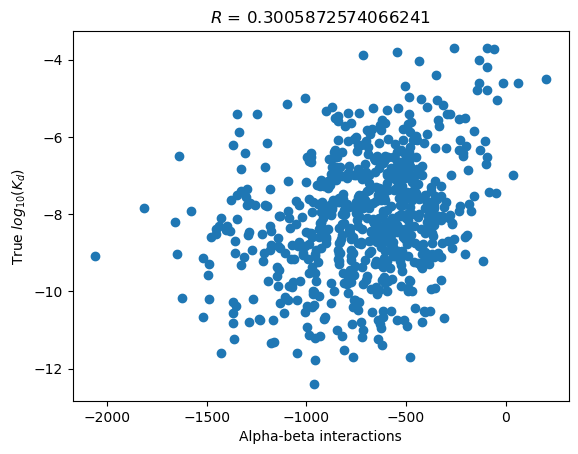

In [3196]:
plt.scatter(alpha_beta_vec, s_kds)
corr = np.corrcoef(alpha_beta_vec, s_kds)[1,0]
plt.title('$R$ = '+str(corr))
plt.xlabel('Alpha-beta interactions')
plt.ylabel('True $log_{10}$($K_d$)')
plt.show()

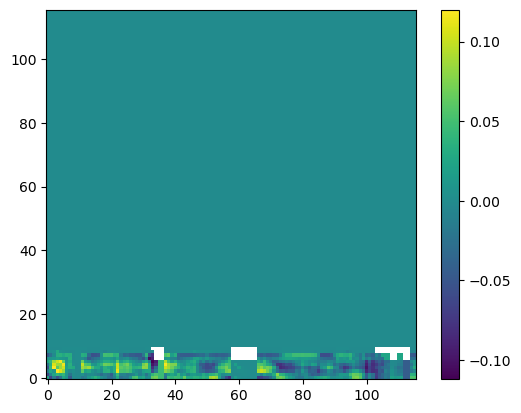

In [3126]:
plt.imshow(corr_matrix.reshape(116, 116), origin='lower')
plt.colorbar()

In [3127]:
s_kds

[array(-4.2006593, dtype=float32),
 array(-7.7695513, dtype=float32),
 array(-11.124939, dtype=float32),
 array(-10.187087, dtype=float32),
 array(-8.420217, dtype=float32),
 array(-6.853872, dtype=float32),
 array(-9.443698, dtype=float32),
 array(-7.853872, dtype=float32),
 array(-6.39794, dtype=float32),
 array(-5.8326826, dtype=float32),
 array(-7.7695513, dtype=float32),
 array(-6.055517, dtype=float32),
 array(-5.5638375, dtype=float32),
 array(-8.21042, dtype=float32),
 array(-6.3467875, dtype=float32),
 array(-6.5199933, dtype=float32),
 array(-6.966576, dtype=float32),
 array(-8.229148, dtype=float32),
 array(-7.7212462, dtype=float32),
 array(-10.008774, dtype=float32),
 array(-10.30103, dtype=float32),
 array(-9.30103, dtype=float32),
 array(-9.1549015, dtype=float32),
 array(-8., dtype=float32),
 array(-8.113509, dtype=float32),
 array(-10.040958, dtype=float32),
 array(-7.7399287, dtype=float32),
 array(-11.244125, dtype=float32),
 array(-7.1366773, dtype=float32),
 array(

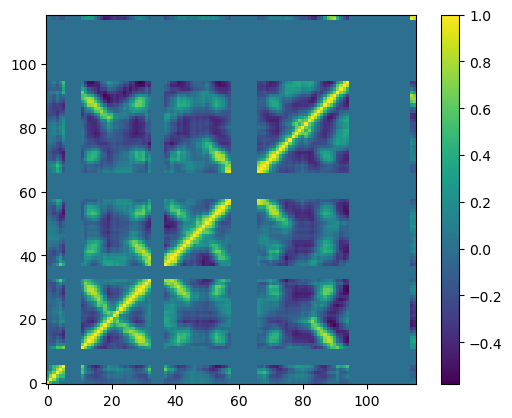

In [3128]:
plt.imshow(imgs[89], origin='lower')
plt.colorbar()

In [2504]:
## Save Neural Network checkpoint
#EPOCH = len(val_losses)
#PATH = "model.pt"
#TR_LOSS = train_losses
#VAL_LOSS = val_losses
#
#torch.save({
#            'epoch': EPOCH,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'tr_loss': TR_LOSS,
#            'val_loss': VAL_LOSS,            
#            }, PATH)

In [3088]:
# Load Neural Network checkpoint

#PATH = "model_complete.pt"
#model = MultiLabelNN()
#optimizer = AdaBelief(model.parameters(), lr=9e-5, eps=1e-8)
#checkpoint = torch.load(PATH)
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#train_losses = checkpoint['tr_loss']
#val_losses = checkpoint['val_loss']

#model.eval()
#10**model(test_sample).detach().numpy()
# - or -
#model.train()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief


In [916]:
# Save Neural Network visualization

#x_val = Variable(val_x)
#model = MultiLabelNN()
#yhat = model(x_val)
#make_dot(yhat, params=dict(list(model.named_parameters()))).render("attached", format="png")

### 